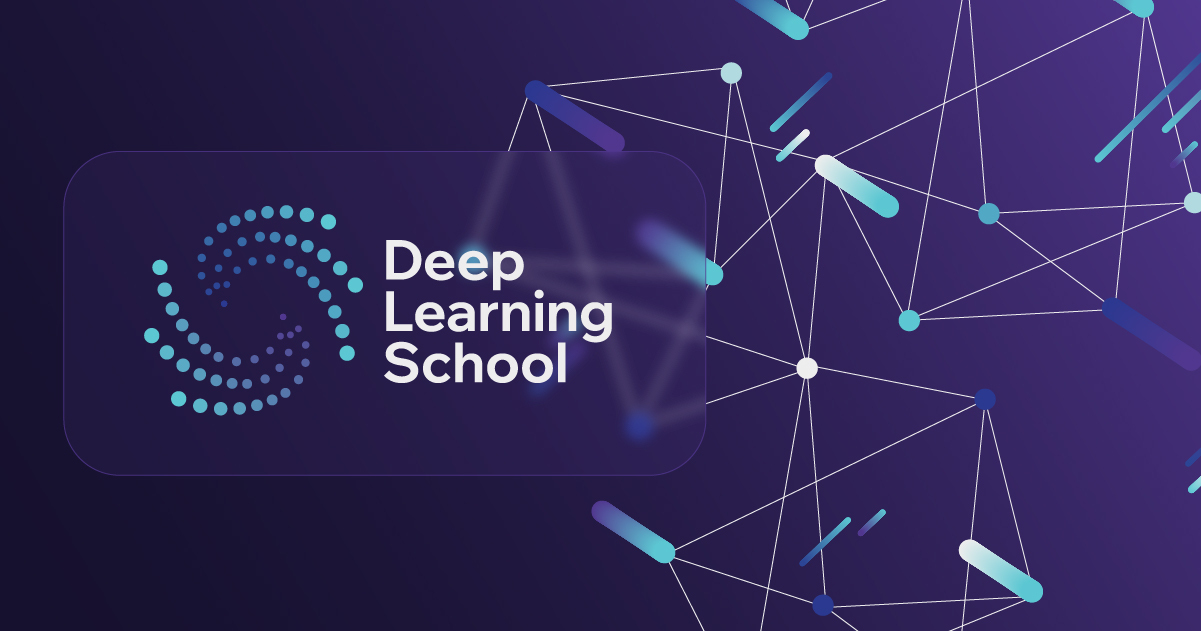

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h1 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h1>



В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [25]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader
import random

sns.set(style="darkgrid", font_scale=1.4)

In [26]:
# Reduce stochasticity

SEED = 42

# PyTorch
torch.manual_seed(SEED)

# CUDA (GPU)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups

# NumPy
np.random.seed(SEED)

# Python's built-in random
random.seed(SEED)

In [27]:
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [28]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

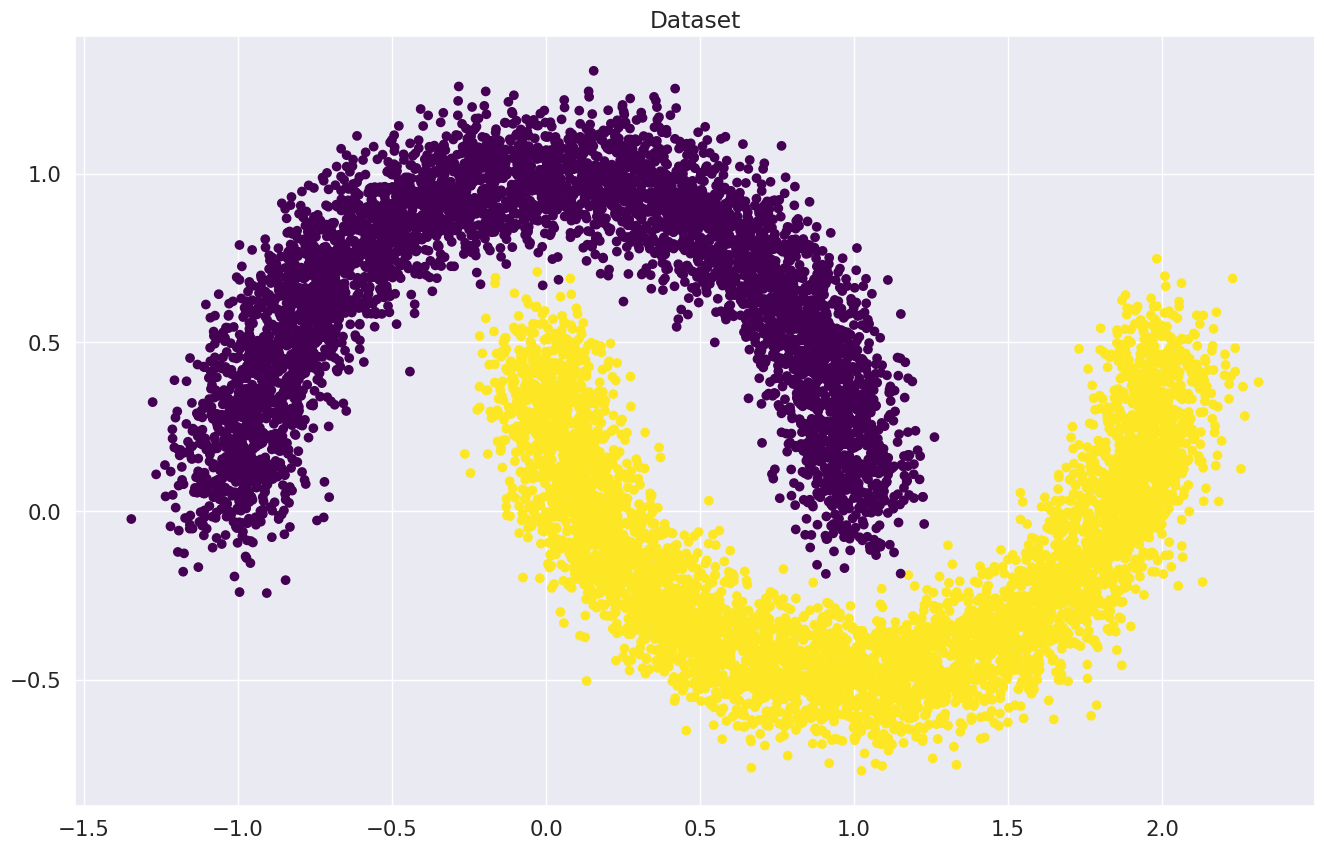

In [29]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [31]:
X_train_t =  torch.tensor(X_train, dtype=torch.float32)
y_train_t =  torch.tensor(y_train, dtype=torch.float32)
X_val_t =  torch.tensor(X_val, dtype=torch.float32)
y_val_t =  torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`.

In [32]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к классу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидой. Чаще всего в качестве сигмоида берут:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [33]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)

    def forward(self, x):
        return self.linear(x)

In [34]:
linear_regression = LinearRegression(in_features=2, out_features=1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

**Ответ:**

In [35]:
2 * 1 + 1

3

In [36]:
from torchsummary import summary
summary(linear_regression, (2,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               3
Total params: 3
Trainable params: 3
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Train loop

Перейдём непосредственно к обучению.

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обнуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [38]:
for name, param in linear_regression.named_parameters():
    print(f"Parameter: {name}, Shape: {param.shape}")

Parameter: linear.weight, Shape: torch.Size([1, 2])
Parameter: linear.bias, Shape: torch.Size([1])


In [41]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.linear.weight)
stop_it = False
for epoch in range(max_epochs):
    random.seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        y_batch = y_batch.view(-1, 1)
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.linear.weight.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}. Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 63.34375
Iteration: 7500
Batch accuracy: 63.625
Iteration: 15000
Batch accuracy: 63.875
Iteration: 22500
Batch accuracy: 64.0
Iteration: 30000
Batch accuracy: 64.0
Iteration: 37500
Batch accuracy: 64.09375
Iteration: 45000
Batch accuracy: 64.09375
Iteration: 52500
Batch accuracy: 64.0625
Iteration: 60000
Batch accuracy: 64.03125
Iteration: 67500
Batch accuracy: 64.0625
Iteration: 75000
Batch accuracy: 64.0625
Iteration: 82500
Batch accuracy: 64.03125
Iteration: 90000
Batch accuracy: 64.03125
Iteration: 97500
Batch accuracy: 64.03125

Iteration: 97551. Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся? (ваш ответ может варьироваться в зависимости от запуска)

**Ответ:** 97551

### Визуализируем результаты

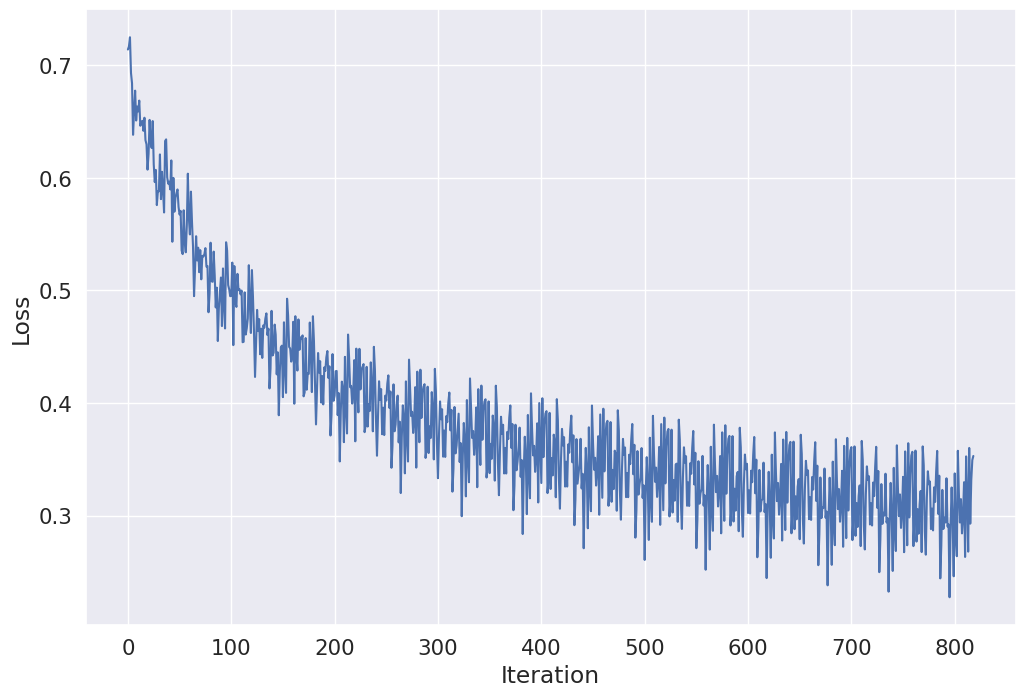

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

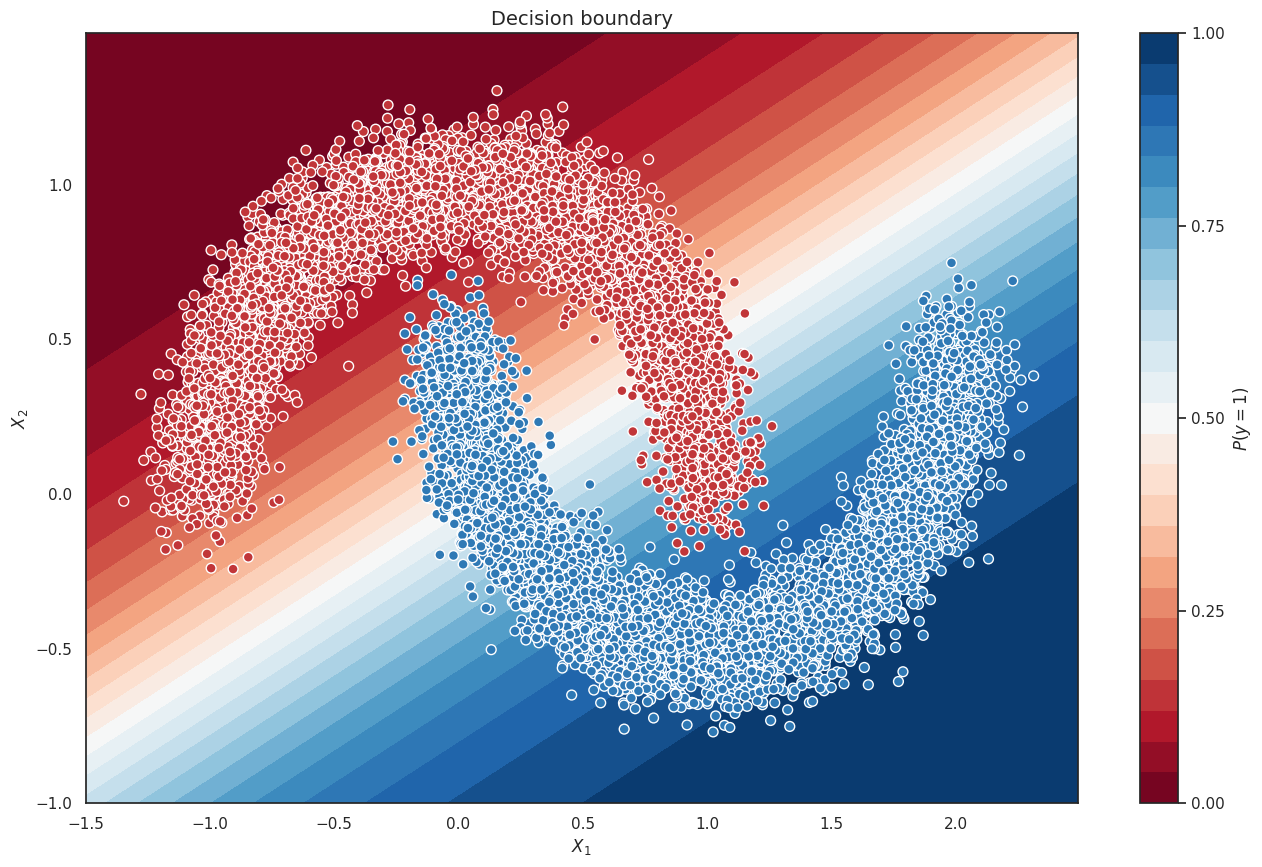

In [43]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [44]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([], dtype='int64')
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions

In [45]:
from sklearn.metrics import accuracy_score

y_predict = predict(val_dataloader, linear_regression)
accuracy_score(y_val, y_predict)

0.858

**Вопрос 3**

Какое `accuracy` получается после обучения? (ваш ответ может варьироваться в зависимости от запуска)

**Ответ:** 0.858

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [47]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

transform = tfs.Compose(
    [tfs.ToTensor()])

BATCH_SIZE = 128

train_dataset = MNIST(root=os.getcwd(), train=True, download=True, transform=transform)
val_dataset = MNIST(root=os.getcwd(), train=False, transform=transform)
train_dataloader =  DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_dataloader =  DataLoader(val_dataset, batch_size=BATCH_SIZE)

100%|██████████| 9.91M/9.91M [00:00<00:00, 52.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.74MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.86MB/s]


## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.


In [48]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

In [95]:
# activation = nn.ELU
# activation = Identical
activation = nn.ReLU
# activation = nn.LeakyReLU


model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

Задайте лосс для обучения (кросс-энтропия).

Вспомним, что такое кросс-энтропийная функция потерь:

$$
L = -\frac{1}{N} \sum_{n=1}^{N} \sum_{i=1}^{C} y_{ni} \log(\hat{y}_{ni})
$$

где:
- $N$ — количество объектов в выборке,
- $C$ — количество классов,
- $y_{ni}$ — истинная метка (one-hot представление),
- $\hat{y}_{ni}$ — предсказанная вероятность модели для класса $i$ на примере $n$.

***Пример расчета***

Рассмотрим пример расчета кросс-энтропийной функции потерь для задачи многоклассовой классификации с 10 классами. Предположим, что у нас есть один объект, истинный класс которого известен, а модель выдала свои предсказания в виде вероятностей для каждого класса.

Пусть объект является цифрой 2. Тогда:
     $$
     y = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
     $$

Пусть модель выдала следующие вероятности для 10 классов:  
     $$
     \hat{y} = [0.1, 0.05, 0.6, 0.15, 0.05, 0.02, 0.01, 0.01, 0.01, 0.0]
     $$

$$
L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$



Только один элемент $y_i$ равен 1, остальные равны 0. Поэтому:

$
L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i) = - y_2 \cdot log(\hat{y}_2) = - 1 \cdot log(0.6) \approx 0.51
$

In [96]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [97]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [98]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
model = model.to(device)
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    np.random.seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 outp = model(x_batch.to(device))
                #  print(outp.shape, y_batch.shape)
                 optimizer.zero_grad()
                 loss = criterion(outp, y_batch.to(device))
                 loss.backward()
                 optimizer.step()
            else:
                 model.eval()
                 with torch.no_grad():
                     outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            # if k == "train":
            #     loss = criterion(outp, y_batch)
            #      # YOUR CODE GOES HERE
            #      # YOUR CODE GOES HERE
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8868166666666667
Loader: valid. Accuracy: 0.8939142857142857
Epoch: 2
Loader: train. Accuracy: 0.94895
Loader: valid. Accuracy: 0.9497428571428571
Epoch: 3
Loader: train. Accuracy: 0.9644333333333334
Loader: valid. Accuracy: 0.9641
Epoch: 4
Loader: train. Accuracy: 0.9738166666666667
Loader: valid. Accuracy: 0.9727142857142858
Epoch: 5
Loader: train. Accuracy: 0.9796666666666667
Loader: valid. Accuracy: 0.9782428571428572
Epoch: 6
Loader: train. Accuracy: 0.9837666666666667
Loader: valid. Accuracy: 0.9819142857142857
Epoch: 7
Loader: train. Accuracy: 0.9875666666666667
Loader: valid. Accuracy: 0.9853142857142857
Epoch: 8
Loader: train. Accuracy: 0.9901333333333333
Loader: valid. Accuracy: 0.9876142857142857
Epoch: 9
Loader: train. Accuracy: 0.9926166666666667
Loader: valid. Accuracy: 0.9899142857142857
Epoch: 10
Loader: train. Accuracy: 0.9937166666666667
Loader: valid. Accuracy: 0.9908142857142858


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

Функции активации добавляют ***нелинейность в модель***, что позволяет сети решать сложные задачи, такие как классификация и регрессия. Без функций активации нейронная сеть была бы линейной моделью, так как ***композиция линейных преобразований*** это ***линейное преобразование***.

**ReLU (Rectified Linear Unit)**
   - Формула: $ f(x) = \max(0, x) $
   - Диапазон значений: $ [0, \infty) $

**Leaky ReLU**
   - Формула: $ f(x) = \max(\alpha x, x) $, где $ \alpha $ — маленькое положительное число (обычно $ \alpha = 0.01 $).
   - Диапазон значений: $ (-\infty, \infty) $

**Exponential Linear Unit (ELU)**
   - Формула:
   $f(x) = $
     \begin{cases}
     x & \text{если } x > 0 \\
     \alpha (e^x - 1) & \text{если } x \leq 0
     \end{cases}
   - Диапазон значений:  $ (-\alpha, \infty) $

**Линейная функция активации**
   - Формула: $ f(x) = x $
   - Диапазон значений: $ (-\infty, \infty) $

   Обратите внимание, что данная функция активации **не добавляет** нелинейности.

После каждого обучения запустите одну из ячеек снизу. Таким образом получается график accuracy/epoch для каждой функции активации.

In [58]:
elu_accuracy = accuracy["valid"].copy()

In [81]:
plain_accuracy = accuracy["valid"].copy()

In [70]:
relu_accuracy = accuracy["valid"].copy()

In [77]:
leaky_relu_accuracy = accuracy["valid"].copy()

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

In [84]:
print(plain_accuracy[-1], elu_accuracy[-1], leaky_relu_accuracy[-1], relu_accuracy[-1], sep='\n')

0.9219285714285714
0.989
0.9906142857142857
0.9907571428571429


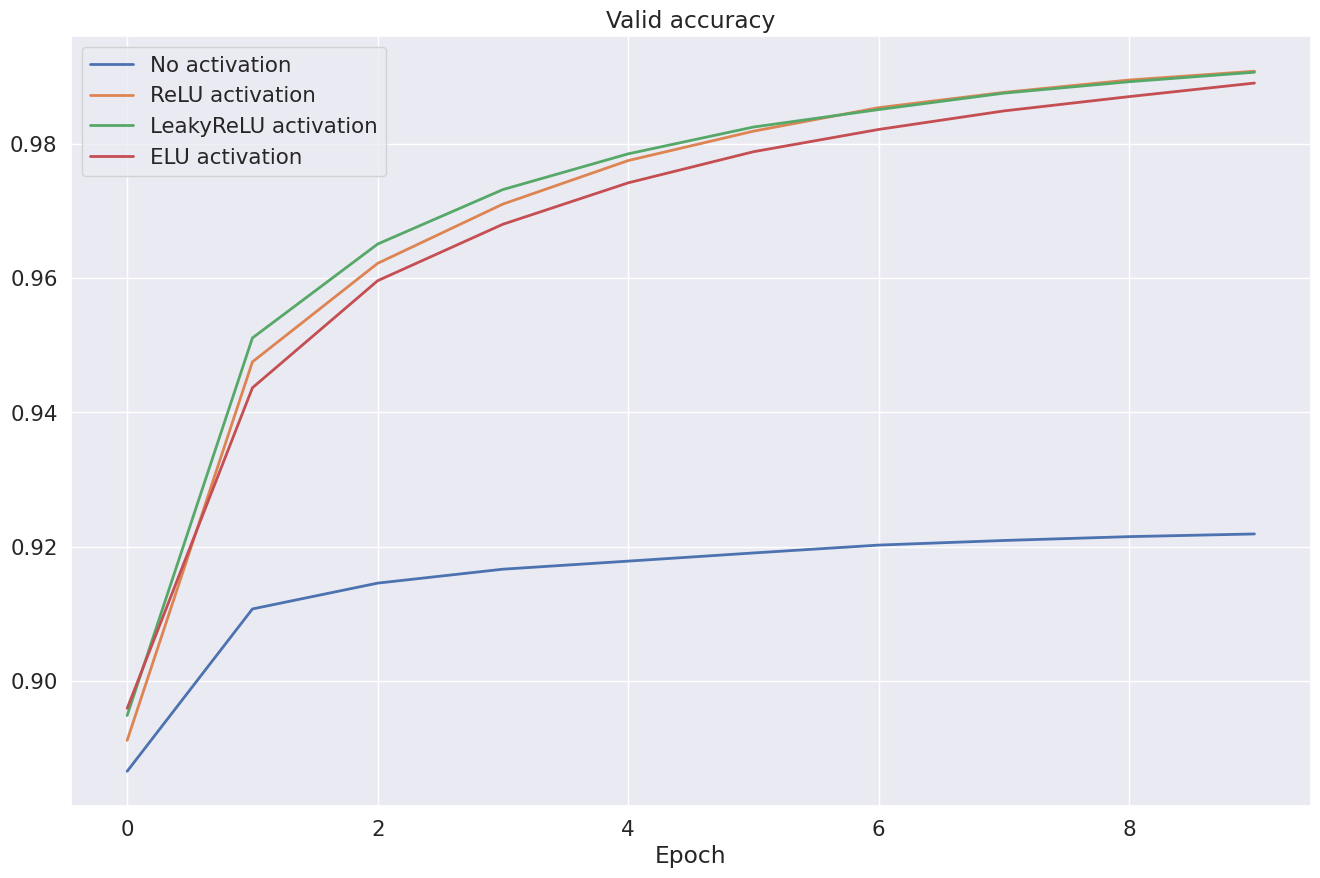

In [85]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [86]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2025-03-31 21:36:21--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   234KB/s    in 0.2s    

2025-03-31 21:36:22 (234 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



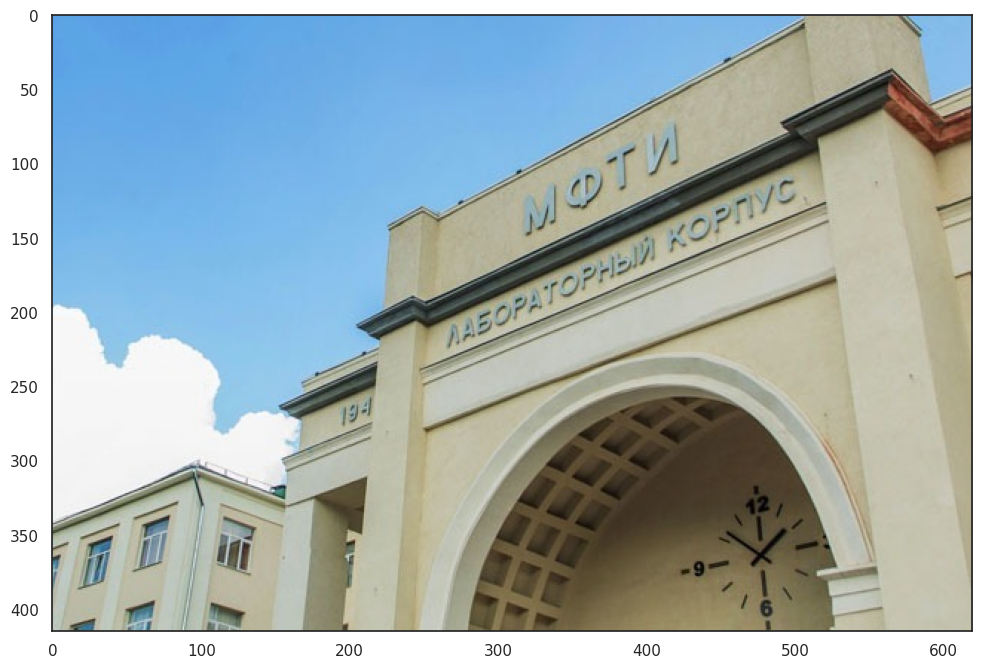

In [87]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [88]:
img_t = torch.from_numpy(RGB_img).type(torch.float32)
print('img_t', img_t.shape)
img_t = img_t.unsqueeze(0)
print('img_t', img_t.shape)
kernel = torch.tensor([
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

print('kernel', kernel.shape)
kernel = kernel.repeat(3, 3, 1, 1)
print('kernel', kernel.shape)
print('img_t', img_t.shape)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
print('img_t', img_t.shape)
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size
print('img_t', img_t.shape)

result = F.conv2d(img_t, kernel)[0]  #
print('result', result.shape)

img_t torch.Size([415, 620, 3])
img_t torch.Size([1, 415, 620, 3])
kernel torch.Size([1, 1, 3, 3])
kernel torch.Size([3, 3, 3, 3])
img_t torch.Size([1, 415, 620, 3])
img_t torch.Size([1, 3, 415, 620])
img_t torch.Size([1, 3, 417, 622])
result torch.Size([3, 415, 620])


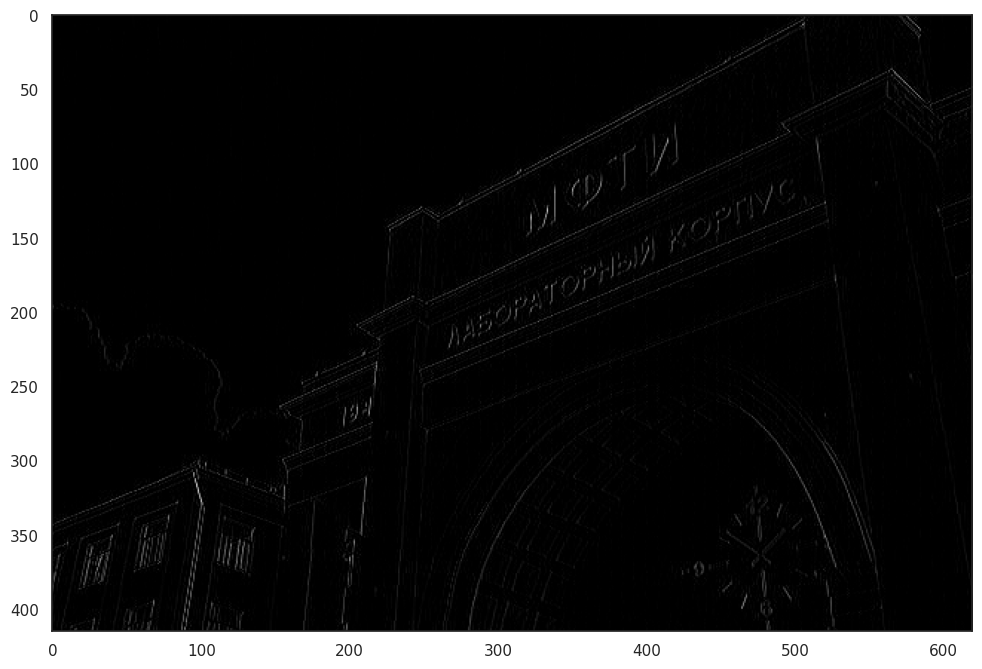

In [89]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

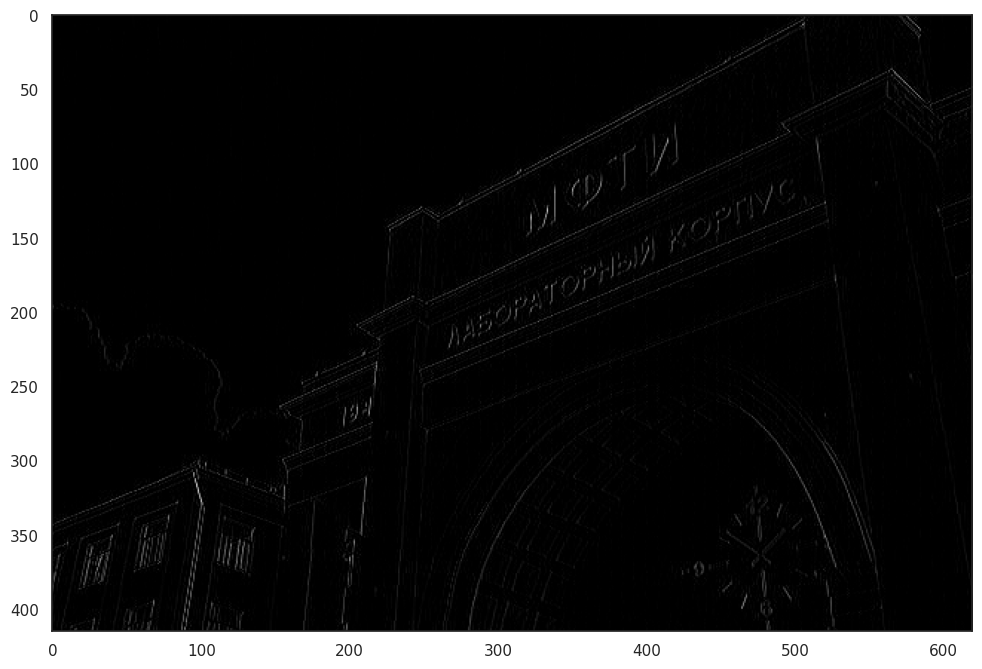

In [90]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** А-3, Б-5, В-4, Г-6, Д-2, Е-1.

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [99]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [100]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [101]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
model.to(device)
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    np.random.seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                outp = model(x_batch.to(device))
                optimizer.zero_grad()
                # print(outp.shape, y_batch.shape)
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct =  (preds == y_batch.to(device)).sum()
            all =  y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            # if k == "train":
            #     loss = criterion(outp, y_batch)
            #      # YOUR CODE GOES HERE
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8570666666666666
Loader: valid. Accuracy: 0.8715857142857143
Epoch: 2
Loader: train. Accuracy: 0.9630166666666666
Loader: valid. Accuracy: 0.9641142857142857
Epoch: 3
Loader: train. Accuracy: 0.9748666666666667
Loader: valid. Accuracy: 0.9751857142857143
Epoch: 4
Loader: train. Accuracy: 0.9806166666666667
Loader: valid. Accuracy: 0.9805714285714285
Epoch: 5
Loader: train. Accuracy: 0.9836333333333334
Loader: valid. Accuracy: 0.9834142857142857
Epoch: 6
Loader: train. Accuracy: 0.98645
Loader: valid. Accuracy: 0.9860285714285715
Epoch: 7
Loader: train. Accuracy: 0.9884
Loader: valid. Accuracy: 0.988
Epoch: 8
Loader: train. Accuracy: 0.9897833333333333
Loader: valid. Accuracy: 0.9893142857142857
Epoch: 9
Loader: train. Accuracy: 0.9914
Loader: valid. Accuracy: 0.9906571428571429
Epoch: 10
Loader: train. Accuracy: 0.9926166666666667
Loader: valid. Accuracy: 0.9917714285714285


In [102]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

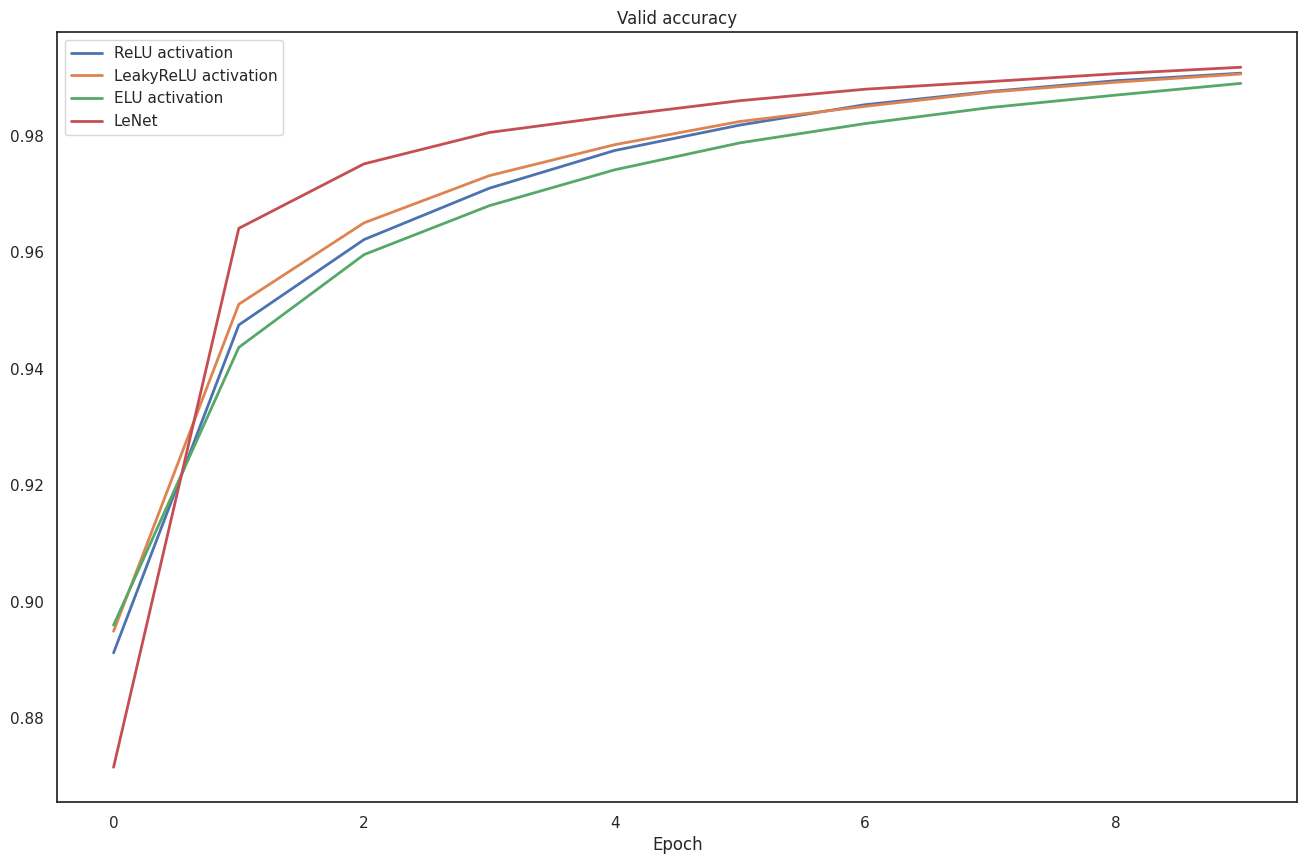

In [103]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99